## K-Means Clustering on unstrucutresd dropout reason column 
- load the original dorpout reason file pulled using SQL queries on the AACT 
- identify 10 structured dropout reasons to recategorize the unstrucutred text in original dropout reason files.

In [ ]:
!pip install unidecode
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.4 MB/s 
     |████████████████████████████████| 6.3 MB 39.4 MB/s 
     |████████████████████████████████| 16.7 MB 220 kB/s 


In [ ]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud
from collections import Counter

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
depression_drop_reason_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Input Files/depression_dropout_reasons.csv")
depression_drop_reason_df['disease_type'] = "Depression"
depression_drop_reason_df['disease_group'] = 'Mood Disorder'
anxiety_drop_reason_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Input Files/anxiety_dropout_reasons.csv")
anxiety_drop_reason_df['disease_type'] = "Anxiety"
anxiety_drop_reason_df['disease_group'] = 'Mood Disorder'
bipolar_drop_reason_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Input Files/bipolar_dropout_reasons.csv")
bipolar_drop_reason_df['disease_type'] = "Bipolar"
bipolar_drop_reason_df['disease_group'] = 'Mood Disorder'
alzheimers_drop_reason_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Input Files/alzheimers_dropout_reasons.csv")
alzheimers_drop_reason_df['disease_type'] = "Alzheimer's Disease"
alzheimers_drop_reason_df['disease_group'] = 'Neurodegenerative Disease'
parkinsons_drop_reason_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Input Files/parkinsons_dropout_reasons.csv")
parkinsons_drop_reason_df['disease_type'] = "Parkinson's Disease"
parkinsons_drop_reason_df['disease_group'] = 'Neurodegenerative Disease'
als_drop_reason_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Input Files/depression_dropout_reasons.csv")
als_drop_reason_df['disease_type'] = "ALS"
als_drop_reason_df['disease_group'] = 'Neurodegenerative Disease'

In [ ]:
# concat all clean dfs tp get master_df
frames = [depression_drop_reason_df, anxiety_drop_reason_df, bipolar_drop_reason_df, alzheimers_drop_reason_df, parkinsons_drop_reason_df, als_drop_reason_df]
master = pd.concat(frames)

#drop first column of no data 
all_disease_drop_df = master.iloc[: , 1:]

In [ ]:
all_disease_drop_df

,nct_id,id,count,reason,disease_type,disease_group
0,NCT00000367,NaN,NaN,NaN,Depression,Mood Disorder
1,NCT00000375,NaN,NaN,NaN,Depression,Mood Disorder
2,NCT00000376,NaN,NaN,NaN,Depression,Mood Disorder
3,NCT00000377,NaN,NaN,NaN,Depression,Mood Disorder
4,NCT00000378,6809416.0,16.0,Lack of Efficacy,Depression,Mood Disorder
...,...,...,...,...,...,...
11688,NCT05427578,NaN,NaN,NaN,ALS,Neurodegenerative Disease
11689,NCT05427981,NaN,NaN,NaN,ALS,Neurodegenerative Disease
11690,NCT05430022,NaN,NaN,NaN,ALS,Neurodegenerative Disease
11691,NCT05431374,NaN,NaN,NaN,ALS,Neurodegenerative Disease


In [ ]:
# fill all nan values with "Unknown"
all_disease_drop_df['reason'] = all_disease_drop_df['reason'].fillna('UNKOWN')

In [ ]:
all_disease_drop_df

,nct_id,id,count,reason,disease_type,disease_group
0,NCT00000367,NaN,NaN,UNKOWN,Depression,Mood Disorder
1,NCT00000375,NaN,NaN,UNKOWN,Depression,Mood Disorder
2,NCT00000376,NaN,NaN,UNKOWN,Depression,Mood Disorder
3,NCT00000377,NaN,NaN,UNKOWN,Depression,Mood Disorder
4,NCT00000378,6809416.0,16.0,Lack of Efficacy,Depression,Mood Disorder
...,...,...,...,...,...,...
11688,NCT05427578,NaN,NaN,UNKOWN,ALS,Neurodegenerative Disease
11689,NCT05427981,NaN,NaN,UNKOWN,ALS,Neurodegenerative Disease
11690,NCT05430022,NaN,NaN,UNKOWN,ALS,Neurodegenerative Disease
11691,NCT05431374,NaN,NaN,UNKOWN,ALS,Neurodegenerative Disease


### Corpus Loading : corpus = text file

In [ ]:
all_disease_drop_df.columns = map(str.lower, all_disease_drop_df.columns)

disease_group = ['Mood Disorder', 'Neurodegenerative Disease']
all_disease_drop_df = all_disease_drop_df.loc[all_disease_drop_df['disease_group'].isin(disease_group)]
all_disease_drop_df.head(6)

,nct_id,id,count,reason,disease_type,disease_group
0,NCT00000367,NaN,NaN,UNKOWN,Depression,Mood Disorder
1,NCT00000375,NaN,NaN,UNKOWN,Depression,Mood Disorder
2,NCT00000376,NaN,NaN,UNKOWN,Depression,Mood Disorder
3,NCT00000377,NaN,NaN,UNKOWN,Depression,Mood Disorder
4,NCT00000378,6809416.0,16.0,Lack of Efficacy,Depression,Mood Disorder
5,NCT00000378,6809417.0,14.0,Lack of Efficacy,Depression,Mood Disorder


In [ ]:
corpus = all_disease_drop_df['reason'].tolist()
corpus[18][0:447]

'UNKOWN'

### Stop Words and Stemming

In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [ ]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
language = 'english'
corpus = processCorpus(corpus, language)
corpus[18][0:460]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'unkown'

### Statistical Weighting of Words

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

52301 rows


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,52291,52292,52293,52294,52295,52296,52297,52298,52299,52300
unkown,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
abnorm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absenc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abstain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,52291,52292,52293,52294,52295,52296,52297,52298,52299,52300
unkown,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
abnorm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absenc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abstain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### K-Means

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

### Silhouette Score 

Silhoette score is a value that is a meaure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)

In [ ]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [ ]:
# Running Kmeans
k = 10
kmeans_results = run_KMeans(k, final_df)

### Cluster Analysis

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


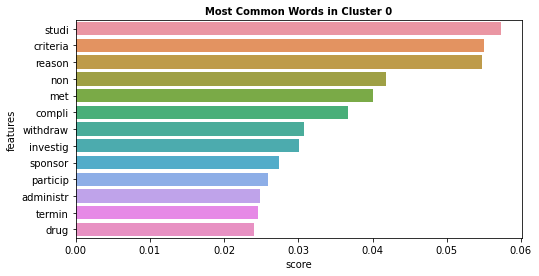

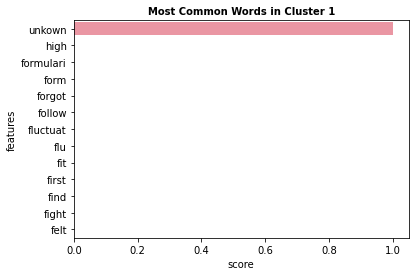

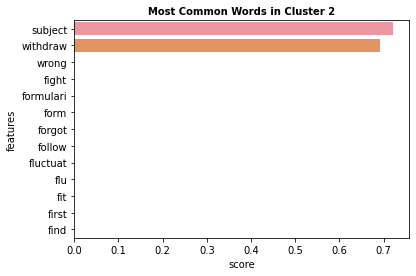

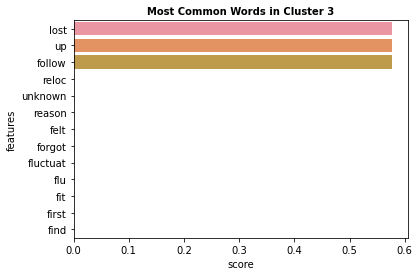

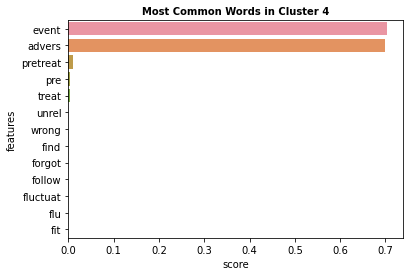

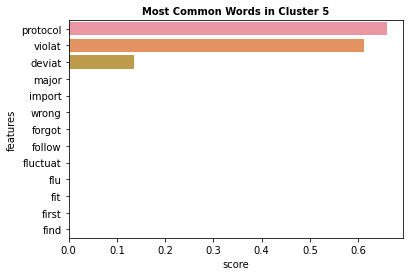

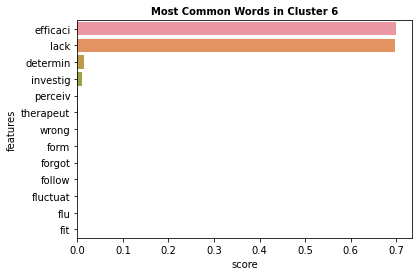

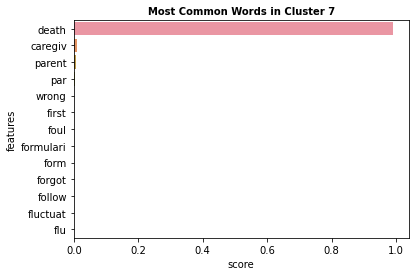

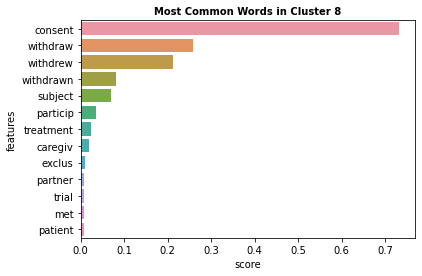

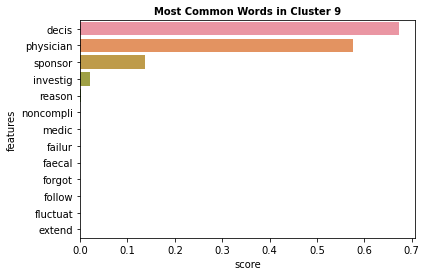

In [ ]:
best_result = 10
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

### Map of Words

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

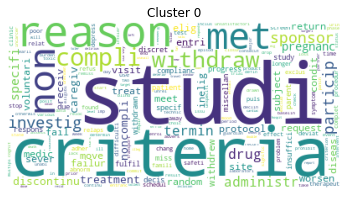

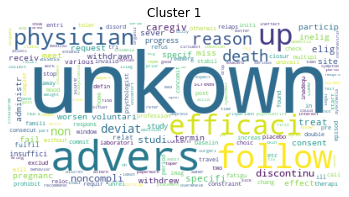

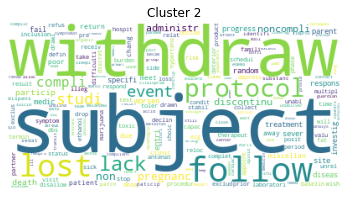

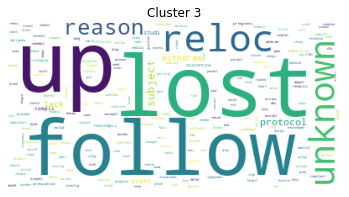

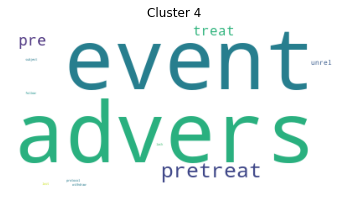

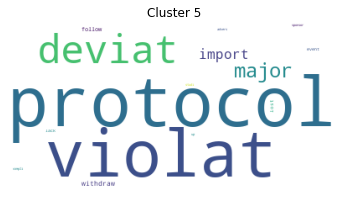

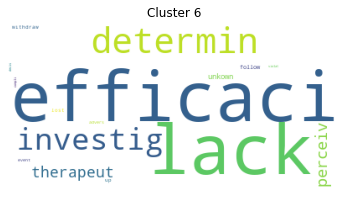

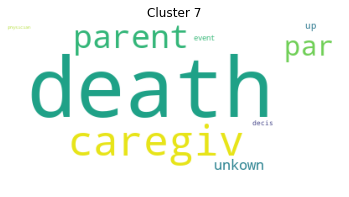

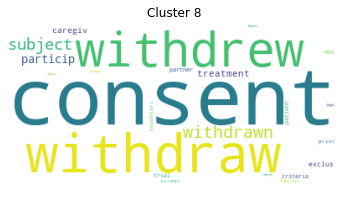

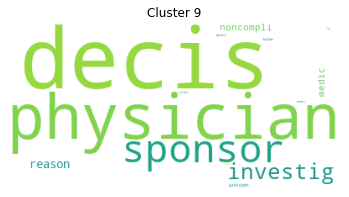

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
all_disease_drop_df['label'] = labels
all_disease_drop_df.head()

,nct_id,id,count,reason,disease_type,disease_group,label
0,NCT00000367,NaN,NaN,UNKOWN,Depression,Mood Disorder,1
1,NCT00000375,NaN,NaN,UNKOWN,Depression,Mood Disorder,1
2,NCT00000376,NaN,NaN,UNKOWN,Depression,Mood Disorder,1
3,NCT00000377,NaN,NaN,UNKOWN,Depression,Mood Disorder,1
4,NCT00000378,6809416.0,16.0,Lack of Efficacy,Depression,Mood Disorder,6


In [ ]:
# replace cluster codes with strings
all_disease_drop_df['label'] = all_disease_drop_df['label'].replace(to_replace=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], value=['inclusion/exclusion criteria issue', 'unknown', 'subject withdrawal', 'lost to follow-up', 'adverse event', 'protocol violation', 'lack of efficacy', 'death', 'consent withdrawn', 'physician decision'])

In [ ]:
Counter(all_disease_drop_df['label'])

Counter({'adverse event': 4269,
         'consent withdrawn': 515,
         'death': 829,
         'inclusion/exclusion criteria issue': 9688,
         'lack of efficacy': 2135,
         'lost to follow-up': 4443,
         'physician decision': 1920,
         'protocol violation': 2518,
         'subject withdrawal': 4866,
         'unknown': 21118})

In [ ]:
all_disease_drop_df.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/master_dropout_df.csv')

## Split master datafraeme into individual disease types

In [ ]:
depression_dropout_df = all_disease_drop_df[all_disease_drop_df['disease_type'] == 'Depression']
anxiety_dropout_df = all_disease_drop_df[all_disease_drop_df['disease_type'] == 'Anxiety']
bipolar_dropout_df = all_disease_drop_df[all_disease_drop_df['disease_type'] == 'Bipolar']
alzheimers_dropout_df = all_disease_drop_df[all_disease_drop_df['disease_type'] == "Alzheimer's Disease"]
parkinsons_dropout_df = all_disease_drop_df[all_disease_drop_df['disease_type'] == "Parkinson's Disease"]
als_dropout_df = all_disease_drop_df[all_disease_drop_df['disease_type'] == 'ALS']

In [ ]:
#write to csv 
depression_dropout_df.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/depression_dropout_df.csv')
anxiety_dropout_df.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/anxiety_dropout_df.csv')
bipolar_dropout_df.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/bipolar_dropout_df.csv')
alzheimers_dropout_df.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/alzheimers_dropout_df.csv')
parkinsons_dropout_df.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/parkinsons_dropout_df.csv')
als_dropout_df.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/als_dropout_df.csv')